In [40]:
import pandas as pd
import numpy as np
import functools
from datetime import datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import pprint
from tensorflow import keras
import matplotlib.pyplot as plt

client = CoinMetricsClient('FeHRFvBh9VfW6an1UgbM')

In [2]:
@functools.lru_cache(maxsize=16)
def get_data(dataType, interval, exchange, market, start_date, end_date, metric = None):
    """
    :param interval: time interval 5m, 10m, 15m, 30m, 1h, 1d, etc.
    :param exchange: binance, coinbase, etc.
    :param market: btc, eth, etc.
    :param start_date: start date of the asset's pricing information. format --> '%Y-%m-%d'
    :param end_date: end date of the asset's pricing information in same format as start date
    :return: returns a dataframe of the security, indexed by date, in the given date range
    
    url for docs: https://docs.coinmetrics.io/info/markets/candles
    """
    if dataType == 'candle':
        data = client.get_market_candles(
            markets = f"{exchange}-{market}-usdt-spot", 
            start_time = start_date, 
            end_time = end_date, 
            frequency = interval,
            end_inclusive = False
        ).to_dataframe()
    elif dataType == 'metrics':
        data = client.get_asset_metrics(
            assets = f"{market}", 
            metrics = f'{metric}',
            start_time = start_date, 
            end_time = end_date, 
            frequency = interval,
            end_inclusive = False
        ).to_dataframe()
    data.set_index('time', inplace=True)
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    
    if dataType == 'metrics':
        data = data[[metric]]
        data = data.resample('1h', label = 'right').sum().fillna(0)

    if data.duplicated().sum() > 0:
        data.drop_duplicates(keep='first', inplace=True)
    
    return data

# Data Pull

In [124]:
btc_candles = get_data('candle','1h', 'binance', 'btc', '2021-01-01', '2022-01-01')
btc_candles['upper_shadow'] = btc_candles['price_high'] - btc_candles['price_open']
btc_candles['lower_shadow'] = btc_candles['price_close'] - btc_candles['price_low']
btc_candles['body'] = btc_candles['price_open'] - btc_candles['price_close']
btc_candles = btc_candles.drop(columns=['market','price_open', 'price_high', 'price_low'])
btc_candles

,price_close,vwap,volume,candle_usd_volume,candle_trades_count,upper_shadow,lower_shadow,body
time,,,,,,,,
2021-01-01 00:00:00+00:00,28995.13,28881.607315,2311.811445,66932443.202746,58389,107.71,304.96,-71.5
2021-01-01 01:00:00+00:00,29409.99,29308.867298,5403.068471,158621473.936272,103896,474.87,449.64,-414.86
2021-01-01 02:00:00+00:00,29194.65,29293.569821,2384.23156,70022179.010751,57646,55.26,74.62,215.35
2021-01-01 03:00:00+00:00,29278.4,29261.245272,1461.345077,42849931.675571,42510,171.75,128.38,-83.15
2021-01-01 04:00:00+00:00,29220.31,29250.867652,2038.046803,59777595.486045,55414,116.59,190.91,58.1
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,45728.28,46118.625515,3851.30902,177728019.640695,87472,2.26,49.32,958.14
2021-12-31 20:00:00+00:00,45879.24,45987.147757,1831.41202,84186633.574805,51300,482.79,201.24,-150.96
2021-12-31 21:00:00+00:00,46333.86,46100.67776,1734.69585,79954413.371817,54579,627.01,567.01,-447.2


# Feature Selection

In [164]:
# assets = client.catalog_assets()
# metrics = client.catalog_metrics()

In [165]:
#UNCOMMENT TO SHOW BLOCK DATA AVAILABLE

# for i in metrics:
#     f = i['frequencies']
#     for j in f:
#         if j['frequency'] == '1b':
#             pprint.pprint(i['display_name'])
#             print ('---------------')
#             pprint.pprint(i['metric'])
#             print ('---------------')
#             pprint.pprint(j['assets'])
#             print ('---------------')
#             pprint.pprint(i['description'])
#             print('====================\n\n')

# Feature Descriptions

AdrActCnt - The sum count of unique addresses that were active in the network (either as 
a recipient or originator of a ledger change) that interval. All parties in 
a ledger change action (recipients and originators) are counted. Individual 
addresses are not double-counted if previously active.

BlkHgt - The count of blocks from the genesis (first) block to the last block of that
interval on the main chain.

FlowInBNBUSD - The sum USD value sent to Binance that interval.

FlowOutBNBUSD - The sum USD value withdrawn from Binance that interval

FlowOutExUSD - The sum USD value withdrawn from exchanges that interval, excluding exchange to exchange activity.

IssTotUSD - The sum USD value of all new native units issued that interval.

RevUSD - The sum USD value of all miner revenue (fees plus newly issued native units) 
that interval.


### These metrics seemed like they would have the greatest impact on BTC's return, but we can experiment with more features moving forward.

In [127]:
#PULL METRIC DATA
metrics = ['AdrActCnt','BlkHgt','FlowInBNBUSD', 'FlowOutBNBUSD', 'FlowOutExUSD', 'IssTotUSD', 'RevUSD']
features = {}
for m in metrics:
    features[m] = get_data('metrics', '1b', 'binance', 'btc', '2021-01-01','2022-01-01',metric = m)

In [128]:
#REINDEX TO MATCH CANDLE DATA
idx = btc_candles.index
for m in metrics:
    features[m] = features[m].reindex(idx, fill_value=0)

In [129]:
#MERGE DATAFRAMES
for m in metrics:
    btc_candles = pd.concat([btc_candles, features[m]], axis = 1)

In [130]:
btc_candles.head()

,price_close,vwap,volume,candle_usd_volume,candle_trades_count,upper_shadow,lower_shadow,body,AdrActCnt,BlkHgt,FlowInBNBUSD,FlowOutBNBUSD,FlowOutExUSD,IssTotUSD,RevUSD
time,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,28995.13,28881.607315,2311.811445,66932443.202746,58389,107.71,304.96,-71.5,0,0,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00+00:00,29409.99,29308.867298,5403.068471,158621473.936272,103896,474.87,449.64,-414.86,59184,4647412,16168268.223297,19995062.770914,35309085.053733,1267574.0,1348326.776593
2021-01-01 02:00:00+00:00,29194.65,29293.569821,2384.23156,70022179.010751,57646,55.26,74.62,215.35,68809,5311388,18730119.111599,11487261.118785,14288513.621595,1464921.625,1530501.654034
2021-01-01 03:00:00+00:00,29278.4,29261.245272,1461.345077,42849931.675571,42510,171.75,128.38,-83.15,62672,4647517,18476129.604552,13867205.005594,23399179.647925,1286059.375,1353187.859143
2021-01-01 04:00:00+00:00,29220.31,29250.867652,2038.046803,59777595.486045,55414,116.59,190.91,58.1,49184,3319685,5451732.129199,4232332.350885,25355022.128272,916622.1875,973392.015833


In [133]:
#GET TARGET VARIABLE -- RETURN
btc_candles = btc_candles.drop(index=btc_candles.index[0])
#USE VWAP RETURN AS OPPOSED TO ABSOLUTE VALUE
btc_candles['vwap'] = btc_candles['vwap'].pct_change()
returns = btc_candles['price_close'].pct_change()
returns.name = 'returns'
btc_candles = pd.concat([btc_candles, returns], axis=1)
btc_candles = btc_candles.drop(columns=['price_close'])
btc_candles.head()

,vwap,volume,candle_usd_volume,candle_trades_count,upper_shadow,lower_shadow,body,AdrActCnt,BlkHgt,FlowInBNBUSD,FlowOutBNBUSD,FlowOutExUSD,IssTotUSD,RevUSD,returns
time,,,,,,,,,,,,,,,
2021-01-01 02:00:00+00:00,<NA>,2384.23156,70022179.010751,57646,55.26,74.62,215.35,68809,5311388,18730119.111599,11487261.118785,14288513.621595,1464921.625,1530501.654034,<NA>
2021-01-01 03:00:00+00:00,-0.001103,1461.345077,42849931.675571,42510,171.75,128.38,-83.15,62672,4647517,18476129.604552,13867205.005594,23399179.647925,1286059.375,1353187.859143,0.002869
2021-01-01 04:00:00+00:00,-0.000355,2038.046803,59777595.486045,55414,116.59,190.91,58.1,49184,3319685,5451732.129199,4232332.350885,25355022.128272,916622.1875,973392.015833,-0.001984
2021-01-01 05:00:00+00:00,-0.003092,1469.956262,42964287.052979,41800,14.97,102.9,33.3,48154,3319710,18200400.539222,14801384.221599,28423625.764866,916276.5625,978722.51528,-0.00114
2021-01-01 06:00:00+00:00,0.000411,1420.726291,41532838.019366,46400,82.99,97.03,12.66,29101,2655786,4419583.997676,15299987.252885,20020169.206307,730309.4375,760089.464003,-0.000434


In [134]:
#SHIFT DATA TO OBTAIN TESTING & TRAINING DATASETS
data = btc_candles.iloc[:, :-1].shift()
data = pd.concat([data, returns], axis = 1)
data.dropna(inplace=True)

In [135]:
data.head()

,vwap,volume,candle_usd_volume,candle_trades_count,upper_shadow,lower_shadow,body,AdrActCnt,BlkHgt,FlowInBNBUSD,FlowOutBNBUSD,FlowOutExUSD,IssTotUSD,RevUSD,returns
time,,,,,,,,,,,,,,,
2021-01-01 04:00:00+00:00,-0.001103,1461.345077,42849931.675571,42510,171.75,128.38,-83.15,62672,4647517,18476129.604552,13867205.005594,23399179.647925,1286059.375,1353187.859143,-0.001984
2021-01-01 05:00:00+00:00,-0.000355,2038.046803,59777595.486045,55414,116.59,190.91,58.1,49184,3319685,5451732.129199,4232332.350885,25355022.128272,916622.1875,973392.015833,-0.00114
2021-01-01 06:00:00+00:00,-0.003092,1469.956262,42964287.052979,41800,14.97,102.9,33.3,48154,3319710,18200400.539222,14801384.221599,28423625.764866,916276.5625,978722.51528,-0.000434
2021-01-01 07:00:00+00:00,0.000411,1420.726291,41532838.019366,46400,82.99,97.03,12.66,29101,2655786,4419583.997676,15299987.252885,20020169.206307,730309.4375,760089.464003,-0.002794
2021-01-01 08:00:00+00:00,-0.005775,2380.180918,69249678.418844,53158,17.63,286.29,81.52,69757,5975577,25333334.074187,8699626.489454,16223352.289039,1644145.375,1703191.166545,-0.00319


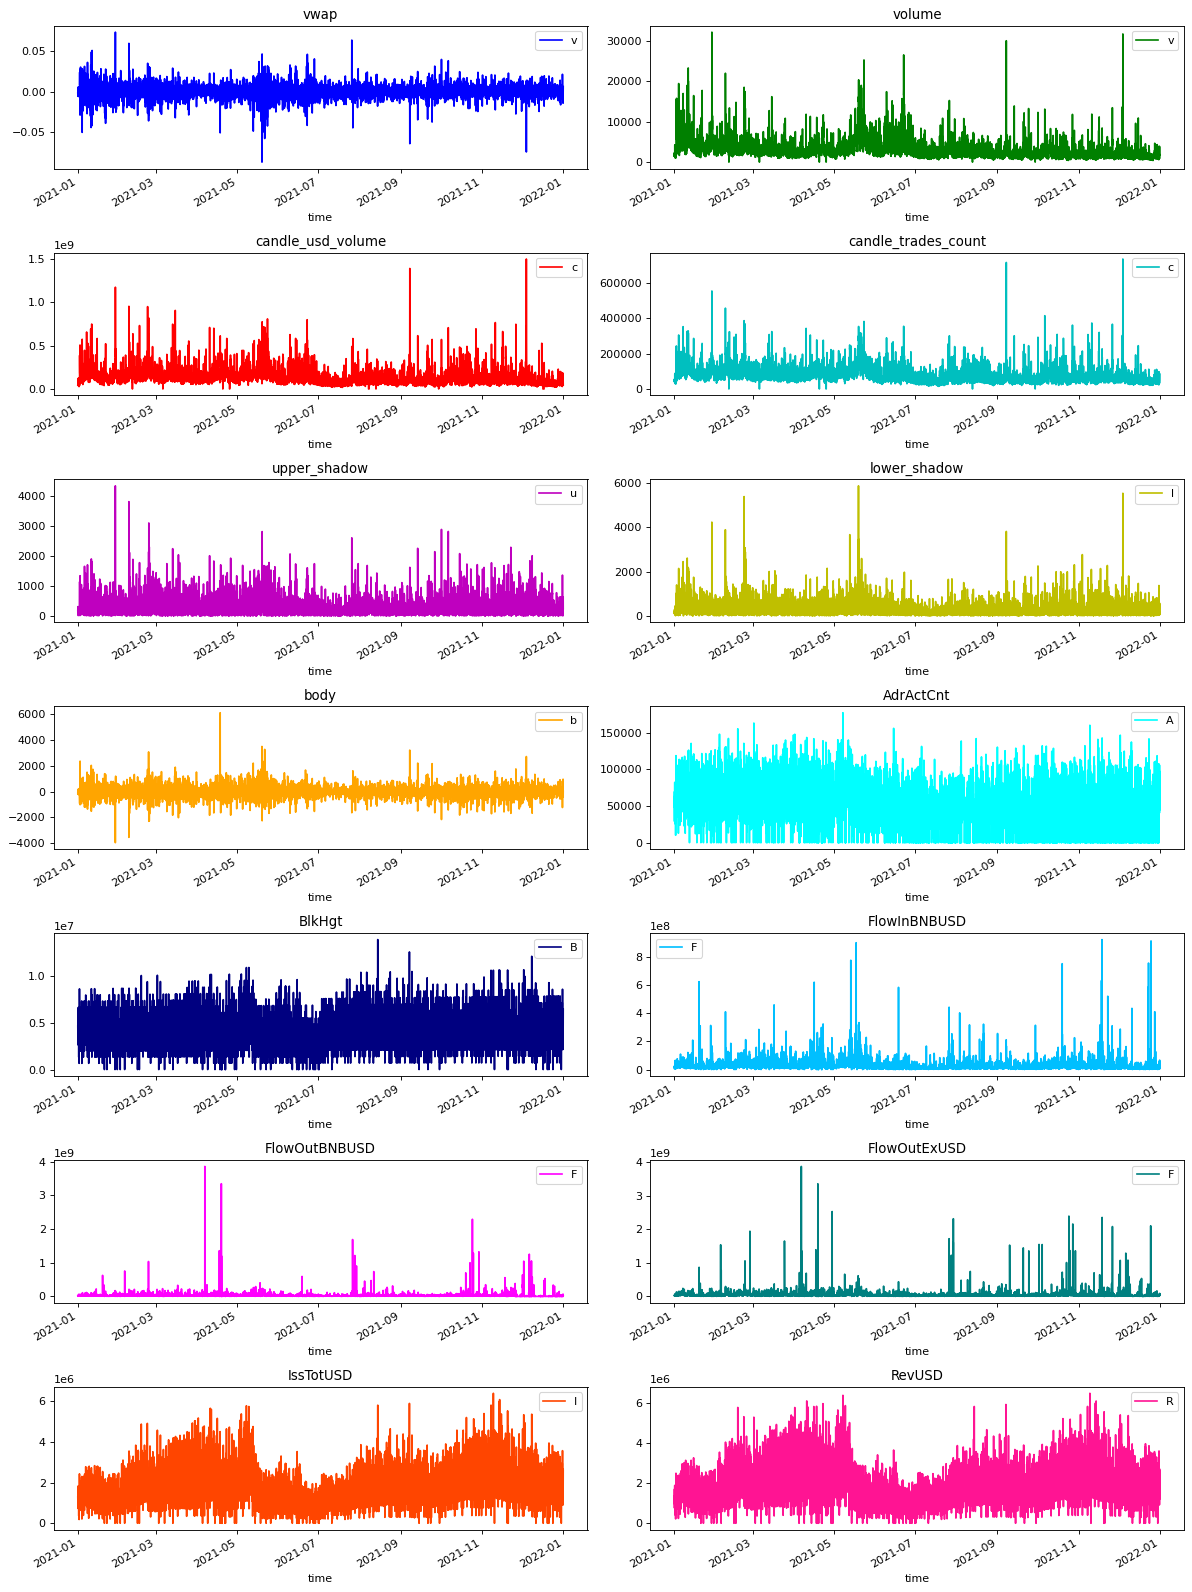

In [136]:
#VISUALIZE FEATURES
featureLabels = data.columns[:-1]
colors = ['b', 'g', 'r', 'c','m','y', 'orange', 'aqua', 'navy', 'deepskyblue', 'fuchsia', 'teal', 'orangered', 'deeppink', 'violet']

fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (15, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
for idx, _ in enumerate(featureLabels):
    key = featureLabels[idx]
    t_data = data[key]
    ax = t_data.plot(ax = axes[idx // 2, idx % 2], title = featureLabels[idx], color = colors[idx])
    ax.legend(featureLabels[idx])
    
plt.tight_layout()

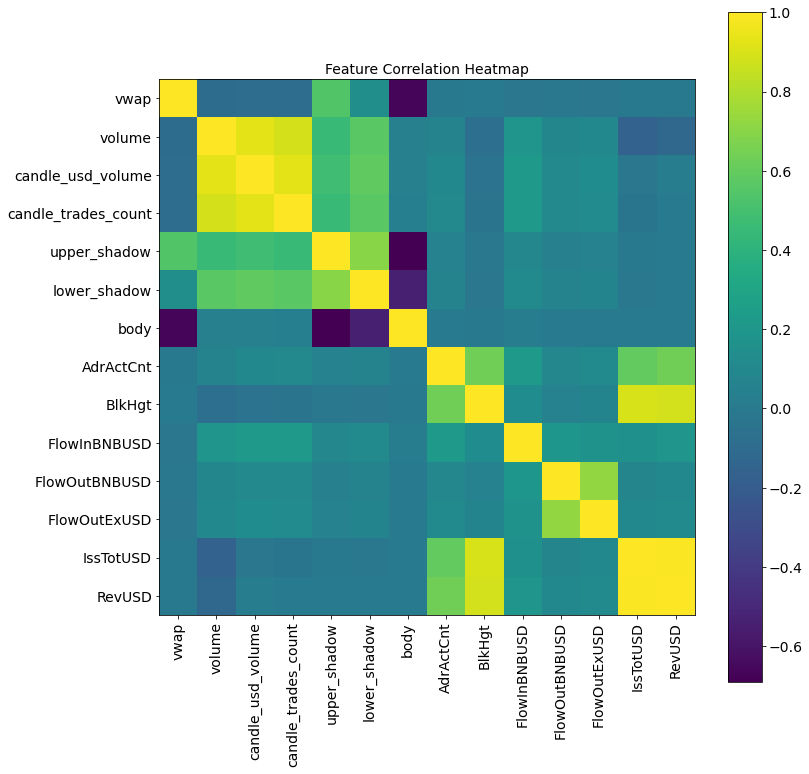

In [169]:
#VISUALIZE CORRELATION AMONGST FEATURES
def show_heatmap(data):
    plt.figure(figsize = (12,12))
    plt.matshow(data.corr(), fignum=1)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(data.iloc[:, :-1])

As we can see, there is a high correlation amongst the coin volume, dollar volume, and trade count. Aside from that, we see relatively low correlation amongst other features. 

# Model - LSTM

In [138]:
#DATA NORMALIZATION FUNCTION
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [139]:
#SPLIT DATASET INTO TRAINING(75%), VALIDATION(20%), TESTING(5%)
num_train_samples = int(0.75 * len(data))
num_validation_samples = int(0.2 * len(data))
num_test_samples = len(data) - num_validation_samples - num_train_samples

In [140]:
#NORMALIZE FEATURES
data.iloc[:, :-1] = normalize(data.iloc[:, :-1], num_train_samples)

In [143]:
#CONVERT DATAFRAMES TO NUMPY ARRAYS FOR MODEL
target = np.asarray(data.returns).astype('float32')
features = np.asarray(data.drop(columns = ['returns'])).astype('float32')

In [144]:
#WE UTILIZE A SEQUENCE LENGTH OF 24 AND BATCH SIZE OF 256 FOR OUR MODEL
sequence_length = 24
batch_size = 256

In [145]:
#USING THE KERAS TIMESERIES DATASET WRAPPER FOR OUR ARRAYS
train_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-sequence_length],
    target[sequence_length:],
    sequence_length = sequence_length,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-sequence_length],
    target[sequence_length:],
    sequence_length = sequence_length,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_validation_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-sequence_length],
    target[sequence_length:],
    sequence_length = sequence_length,
    batch_size = batch_size,
    start_index = num_train_samples + num_validation_samples
)

In [146]:
#USING A CALLBACK TO AVOID OVERFITTING
callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 3)

#CONSTRUCTION OF OUR MODEL - 2 LSTM LAYERS, 2 DROPOUT LAYERS, 1 DENSE OUTPUT LAYER
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = keras.layers.LSTM(64, activation = 'tanh',recurrent_dropout = 0.25, return_sequences = True)(inputs)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64, activation = 'tanh', recurrent_dropout = 0.25)(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

#COMPILE OUR MODEL WITH THE RMSPROP COMPISER, MONITORING MSE AS OUR LOSS FUNCITON AND GAUGING PERFORMANCE 
#BY LOOKING AT MEAN ABSOLUTE ERROR
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

#TRAIN OUR MODEL WITH 50 EPOCHS & USING OUR VALIDATION DATASET TO GAUGE PERFORMANCE
history = model.fit(train_dataset,
                    epochs = 50, 
                    validation_data = val_dataset, 
                    callbacks = callback)

Epoch 1/50
26/26 [==============================] - 7s 135ms/step - loss: 0.0096 - mae: 0.0651 - val_loss: 6.4508e-04 - val_mae: 0.0217
Epoch 2/50
26/26 [==============================] - 3s 122ms/step - loss: 0.0022 - mae: 0.0355 - val_loss: 8.1900e-04 - val_mae: 0.0251
Epoch 3/50
26/26 [==============================] - 3s 127ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 3.7393e-04 - val_mae: 0.0165
Epoch 4/50
26/26 [==============================] - 3s 126ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 2.1601e-04 - val_mae: 0.0126
Epoch 5/50
26/26 [==============================] - 3s 130ms/step - loss: 5.7580e-04 - mae: 0.0182 - val_loss: 6.9202e-05 - val_mae: 0.0064
Epoch 6/50
26/26 [==============================] - 3s 130ms/step - loss: 5.2279e-04 - mae: 0.0170 - val_loss: 1.0542e-04 - val_mae: 0.0085
Epoch 7/50
26/26 [==============================] - 3s 131ms/step - loss: 3.8465e-04 - mae: 0.0146 - val_loss: 5.5212e-05 - val_mae: 0.0054
Epoch 8/50
26/26 [==================

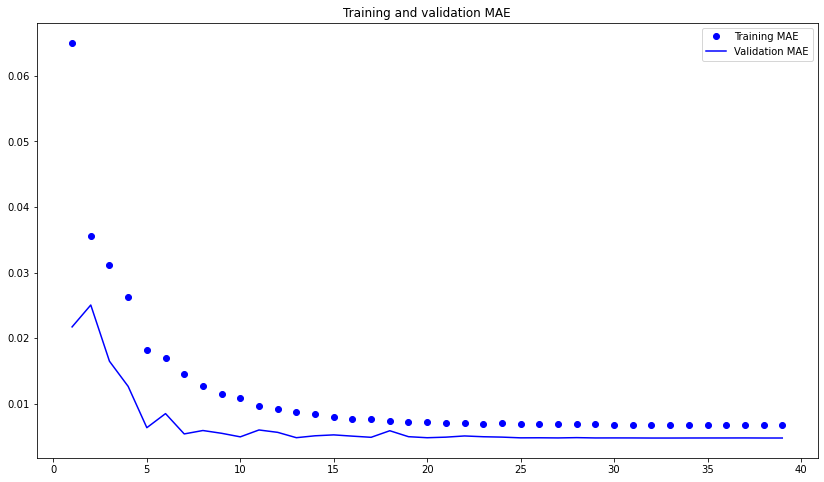

In [147]:
#VISUALIZE OUR TRAINING AND VALIDATION MAE
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize = (14,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [151]:
#EVALUATE OUR MODEL
model.evaluate(test_dataset)

2/2 [==============================] - 0s 23ms/step - loss: 3.5485e-05 - mae: 0.0044


[3.5485372791299596e-05, 0.004447345621883869]

### Our model achieves a mean absolute error of about 44 basis points when predicting return.

In [160]:
#COMPARE MODEL PREDICTIONS WITH OBSERVED RETURNS
predictions = []
for i in np.arange(4):
    pred = features[-29+i:-5+i].reshape(1, 24, 14)
    predictions.append(model.predict(pred, verbose = False)[0][0])
    
predictions

[0.0012297849, 0.0013537281, 0.001501977, 0.0007601073]

In [159]:
target[-4:]

array([ 0.00330124,  0.00990906, -0.00064467, -0.00188018], dtype=float32)